Installing necessary modules

In [1]:
!pip install reverse_geocoder
!pip install geocoder
!pip install folium


Importing necessary packages and extracting dataset zip file

In [2]:
import pandas as pd
import zipfile
import reverse_geocoder as rg 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
sns.set()
import types
from botocore.client import Config
import folium
from geopy.geocoders import Nominatim

zf = zipfile.ZipFile('/content/test.zip') 
df_test = pd.read_csv(zf.open('test.csv'))

zf1 = zipfile.ZipFile('/content/train.zip') 
df_train = pd.read_csv(zf1.open('train.csv'))

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Computing Correlation matrix for features with numeric values

In [3]:
df_train.corr()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
vendor_id,1.000000,0.287415,0.007820,0.001742,0.001528,0.004496,0.020304
passenger_count,0.287415,1.000000,0.002169,-0.005125,-0.000343,-0.002762,0.008471
pickup_longitude,0.007820,0.002169,1.000000,0.022568,0.783582,0.100190,0.026542
pickup_latitude,0.001742,-0.005125,0.022568,1.000000,0.114884,0.494038,-0.029204
dropoff_longitude,0.001528,-0.000343,0.783582,0.114884,1.000000,0.124873,0.014678
dropoff_latitude,0.004496,-0.002762,0.100190,0.494038,0.124873,1.000000,-0.020677
trip_duration,0.020304,0.008471,0.026542,-0.029204,0.014678,-0.020677,1.000000


In [4]:
df_train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


Using date time to add day column

In [5]:
df_train['pickup_datetime']=pd.to_datetime(df_train['pickup_datetime'])
df_train['dropoff_datetime']=pd.to_datetime(df_train['dropoff_datetime'])

df_train['pickup_day']=df_train['pickup_datetime'].dt.day_name()
df_train['dropoff_day']=df_train['dropoff_datetime'].dt.day_name()

Plot of Number of pickups done on each day 

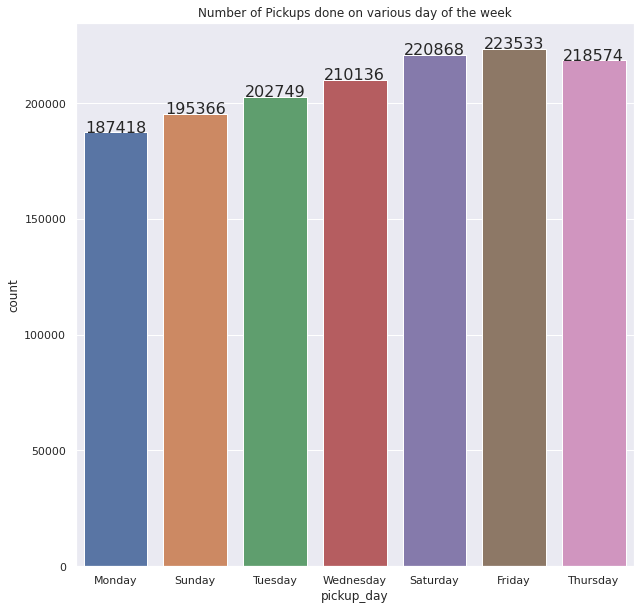

In [6]:
figure,ax=plt.subplots(figsize=(10,10))

g = sns.countplot(x='pickup_day',data=df_train,ax=ax)
ax.set_title('Number of Pickups done on various day of the week')

for p in g.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2,height + 3,height,ha="center",fontsize=16)


Adding a timezone to classify the hours as : Morning - 4:01am - 11:00am
                                             Midday - 11:01am - 16:00pm
                                             Evening - 16:01pm - 22:00pm
                                             Late Night - 22:01pm - 04:00am 

In [7]:
def timezone(x):
    if x>=datetime.time(4, 0, 1) and x <=datetime.time(11, 0, 0):
        return 'morning'
    elif x>=datetime.time(11, 0, 1) and x <=datetime.time(16, 0, 0):
        return 'midday'
    elif x>=datetime.time(16, 0, 1) and x <=datetime.time(22, 0, 0):
        return 'evening'
    elif x>=datetime.time(22, 0, 1) or x <=datetime.time(4, 0, 0):
        return 'late night'
    
df_train['pickup_timezone']=df_train['pickup_datetime'].apply(lambda x :timezone(datetime.datetime.strptime(str(x), "%Y-%m-%d %H:%M:%S").time()) )
df_train['dropoff_timezone']=df_train['dropoff_datetime'].apply(lambda x :timezone(datetime.datetime.strptime(str(x), "%Y-%m-%d %H:%M:%S").time()) )

Plot of distribution of pickup in various parts of the day

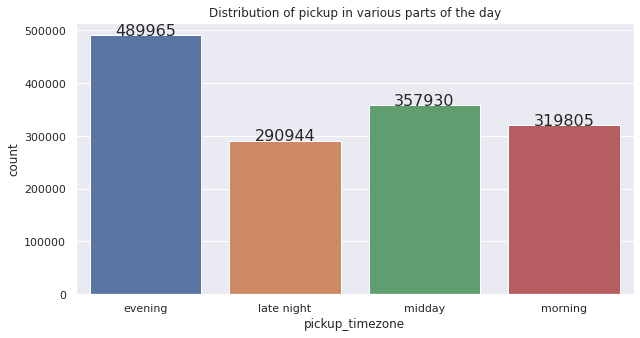

In [8]:
figure,ax=plt.subplots(figsize=(10,5))
g = sns.countplot(x='pickup_timezone',data=df_train,ax=ax)
ax.set_title('Distribution of pickup in various parts of the day')

for p in g.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2,height + 3,height,ha="center",fontsize=16)


Plot of distribution of pickups based on time

Text(0, 0.5, 'Duration')

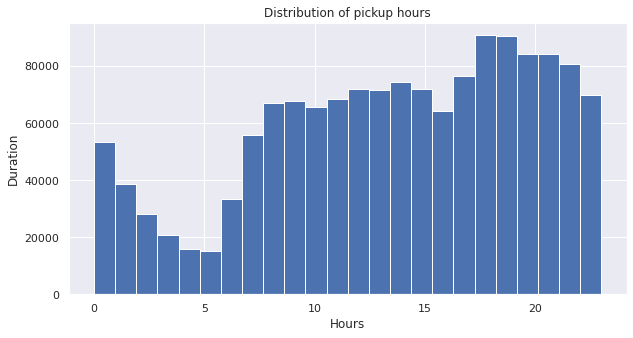

In [9]:
figure,ax=plt.subplots(figsize=(10,5))
df_train['pickup_hour']=df_train['pickup_datetime'].dt.hour
df_train.pickup_hour.hist(bins=24,ax=ax)
ax.set_title('Distribution of pickup hours')
ax.set_xlabel('Hours')
ax.set_ylabel('Duration')

Plot of trip duration to analyze outliers

Text(0.5, 1.0, 'A boxplot depicting the pickup duration distribution')

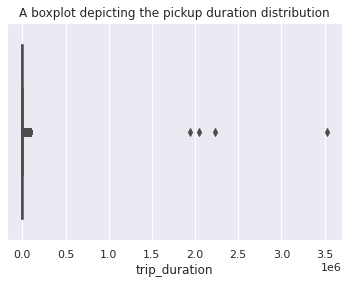

In [10]:
sns.boxplot(df_train['trip_duration'], orient='horoizontal')
plt.title('A boxplot depicting the pickup duration distribution')

Printing to check for largest values to identify outliers and got that four values that are out of range and they are replaced by median value 

In [11]:
print(df_train['trip_duration'].nlargest(10))

978383     3526282
924150     2227612
680594     2049578
355003     1939736
1234291      86392
295382       86391
73816        86390
59891        86387
1360439      86385
753765       86379
Name: trip_duration, dtype: int64


In [12]:
median = df_train.loc[df_train['trip_duration']<86393, 'trip_duration'].median()
df_train.loc[df_train.trip_duration > 86393, 'trip_duration'] = np.nan
df_train.fillna(median,inplace=True)

Text(0.5, 1.0, 'Distribution of the pickup ditribution after the treatment of outliers')

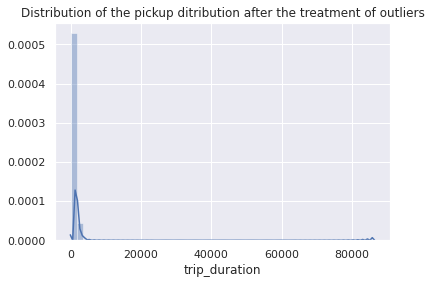

In [13]:
sns.distplot(df_train['trip_duration'])
plt.title('Distribution of the pickup ditribution after the treatment of outliers')

since the values are skewed we are splitting into intervales:
1. less than 30 mins
2. 30-60 mins
3. 60-90 mins
4. 90-120 mins
5. greater than 120 mins 

In [14]:
bins=np.array([0,1800,3600,5400,7200,90000])
df_train['duration_time']=pd.cut(df_train.trip_duration,bins,labels=["< 30", "30-60", "60-90","90-120",">120"])

Text(0.5, 1.0, 'The distribution of Pick up Longitude')

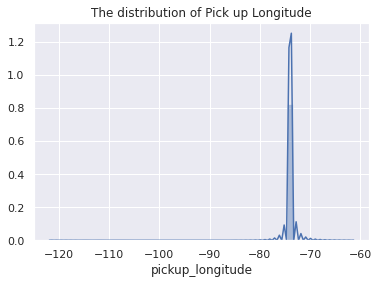

In [15]:
sns.distplot(df_train['pickup_longitude'])
plt.title('The distribution of Pick up Longitude')

Average Trip Duration per Pickup day

Text(0.5, 1.0, 'The Average Trip Duration per PickUp Day of the week')

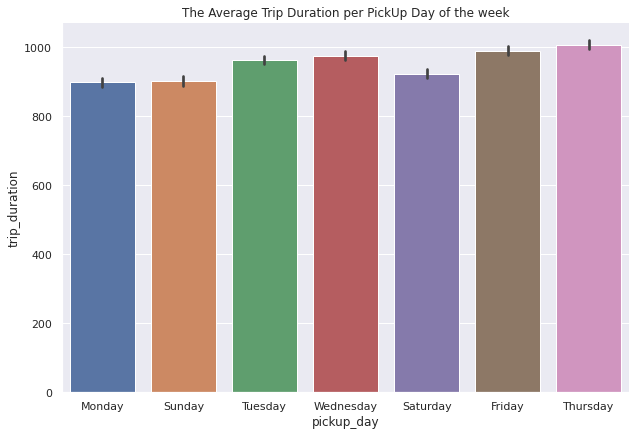

In [16]:
sns.catplot(x="pickup_day",y="trip_duration",kind="bar",data=df_train,height=6,aspect=1.5)
plt.title('The Average Trip Duration per PickUp Day of the week')


Analysing Trip Duration 

In [17]:
df_train['trip_duration'].nlargest(5)

1234291    86392.0
295382     86391.0
73816      86390.0
59891      86387.0
1360439    86385.0
Name: trip_duration, dtype: float64

In [18]:
df_train['trip_duration'].min()

1.0

Trip Duration cannot be 1 min, this may be due to error and they are removed

In [19]:
df_train=df_train[df_train.trip_duration!=df_train.trip_duration.min()]

Calculating new trip duration in hours

In [20]:
df_train['trip_duration_hour']=df_train['trip_duration']/3600 

Passenger count per vendor id and the outliers here are removed as well

In [21]:
df_train.passenger_count.value_counts()

1    1033509
2     210317
5      78088
3      59896
6      48333
4      28404
0         59
7          3
9          1
8          1
Name: passenger_count, dtype: int64

In [22]:
df_train=df_train[df_train.passenger_count<=6]
df_train=df_train[df_train.passenger_count!=0]

Trip distance calculation

In [23]:
from math import radians, cos, sin, asin, sqrt
def haversine(df):
    lat1, lon1, lat2, lon2 = df.pickup_latitude,df.pickup_longitude,df.dropoff_latitude,df.dropoff_longitude 
    R = 3959.87433 # this is in miles.  For Earth radius in kilometers use 6372.8 km
    dLat = radians(lat2 - lat1)
    dLon = radians(lon2 - lon1)
    lat1 = radians(lat1)
    lat2 = radians(lat2)
    a = sin(dLat/2)**2 + cos(lat1)*cos(lat2)*sin(dLon/2)**2
    c = 2*asin(sqrt(a))
    return R * c

In [24]:
df_train['distance'] = df_train.apply(lambda x: haversine(x), axis = 1)

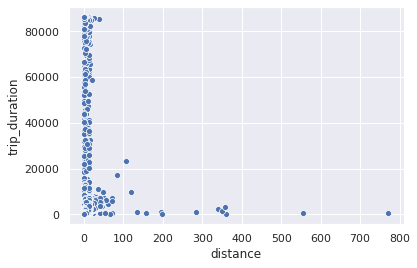

In [25]:
sns.scatterplot(x='distance',y='trip_duration',data=df_train)

Rows with trip distance zero are replaced with mean distance

In [26]:
print('The no of rows with distance =0 are {}'.format(len(df_train[df_train.distance==0])))

The no of rows with distance =0 are 5876


In [27]:
mean_dist=df_train['distance'].mean()
df_train.loc[df_train['distance']==0,'distance']=mean_dist

Speed is calculated

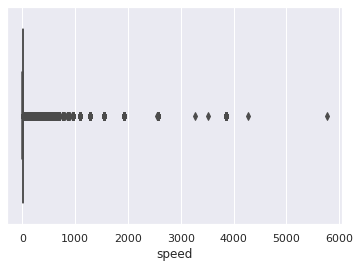

In [28]:
df_train['speed']=df_train['distance']/df_train['trip_duration_hour']
sns.boxplot(df_train['speed'])

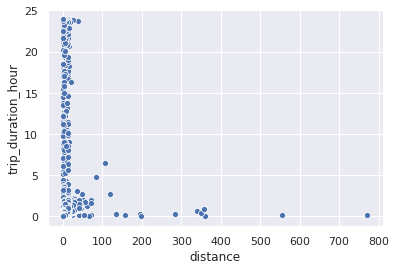

In [29]:
sns.scatterplot(x='distance',y='trip_duration_hour',data=df_train)

Since some distance can be longer and will become outlier hence to keep it to same scale log distance measure is used

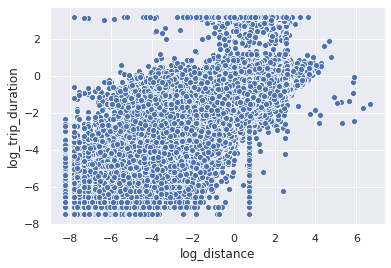

In [30]:
df_train['log_distance']=np.log(df_train.distance)
df_train['log_trip_duration']=np.log(df_train.trip_duration_hour)
sns.scatterplot(x='log_distance',y='log_trip_duration',data=df_train)

In [31]:
df_train=df_train[df_train.log_trip_duration<2]


we are not going to use all features as some feature are related like speed and distance

In [32]:
df_train.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'pickup_day', 'dropoff_day', 'pickup_timezone',
       'dropoff_timezone', 'pickup_hour', 'duration_time',
       'trip_duration_hour', 'distance', 'speed', 'log_distance',
       'log_trip_duration'],
      dtype='object')

In [33]:
df_train['pickup_day']=df_train['pickup_datetime'].dt.day_name()
df_train['dropoff_day']=df_train['dropoff_datetime'].dt.day_name()
df_train['pickup_month']=df_train['pickup_datetime'].dt.month
df_train['dropoff_month']=df_train['dropoff_datetime'].dt.month

Added month

In [34]:
data2=df_train.loc[:,['passenger_count','store_and_fwd_flag','trip_duration', 'pickup_day', 'dropoff_day', 'pickup_month','dropoff_month','pickup_timezone','dropoff_timezone','speed','log_distance','distance']]



One hot encoding for textual features so that model can be trained well

In [35]:
data2=pd.get_dummies(data2,columns=['store_and_fwd_flag','pickup_day','dropoff_day','pickup_month','dropoff_month','pickup_timezone', 'dropoff_timezone'])

In [36]:
data2.corr()

,passenger_count,trip_duration,speed,log_distance,distance,store_and_fwd_flag_N,store_and_fwd_flag_Y,pickup_day_Friday,pickup_day_Monday,pickup_day_Saturday,pickup_day_Sunday,pickup_day_Thursday,pickup_day_Tuesday,pickup_day_Wednesday,dropoff_day_Friday,dropoff_day_Monday,dropoff_day_Saturday,dropoff_day_Sunday,dropoff_day_Thursday,dropoff_day_Tuesday,dropoff_day_Wednesday,pickup_month_1,pickup_month_2,pickup_month_3,pickup_month_4,pickup_month_5,pickup_month_6,dropoff_month_1,dropoff_month_2,dropoff_month_3,dropoff_month_4,dropoff_month_5,dropoff_month_6,dropoff_month_7,pickup_timezone_evening,pickup_timezone_late night,pickup_timezone_midday,pickup_timezone_morning,dropoff_timezone_evening,dropoff_timezone_late night,dropoff_timezone_midday,dropoff_timezone_morning
passenger_count,1.000000,0.014840,-8.371816e-03,0.013364,0.010333,0.021781,-0.021781,-0.000869,-0.009030,0.020798,0.015736,-0.008423,-0.008766,-0.009791,-0.001052,-0.009012,0.020656,0.016156,-0.008493,-0.008901,-0.009769,0.003262,-0.001305,-0.000946,0.001430,-0.000609,-0.001789,0.003285,-1.322321e-03,-0.000947,0.001437,-0.000611,-0.001765,-0.001433,0.004365,0.013296,0.003481,-0.021441,0.004080,0.013569,0.003266,-0.021682
trip_duration,0.014840,1.000000,-2.447185e-02,0.695923,0.697010,-0.027153,0.027153,0.019090,-0.015364,-0.036965,-0.043654,0.037657,0.011138,0.025871,0.018472,-0.015595,-0.036448,-0.041034,0.036017,0.010967,0.025742,-0.030156,-0.031175,-0.013410,0.007588,0.031737,0.034898,-0.030282,-3.114073e-02,-0.013488,0.007632,0.031811,0.034722,0.009310,0.006561,-0.045741,0.064992,-0.030907,0.026789,-0.030560,0.045086,-0.047938
speed,-0.008372,-0.024472,1.000000e+00,0.069580,0.102036,-0.004903,0.004903,-0.004350,0.004483,0.002637,0.014343,-0.005425,-0.005108,-0.005864,-0.004219,0.004525,0.002670,0.013957,-0.005374,-0.005081,-0.005847,0.001245,-0.000002,0.001600,-0.001221,-0.000843,-0.000772,0.001234,2.387183e-07,0.001602,-0.001212,-0.000850,-0.000763,-0.000122,-0.007888,0.020278,-0.017031,0.007135,-0.009320,0.019617,-0.016973,0.009076
log_distance,0.013364,0.695923,6.957985e-02,1.000000,0.743967,-0.017481,0.017481,-0.006124,0.003718,-0.000845,0.030208,-0.004107,-0.011360,-0.010326,-0.006068,0.003555,-0.000408,0.031300,-0.005157,-0.011327,-0.010840,-0.008813,-0.013918,0.001100,0.001276,0.010411,0.009645,-0.008908,-1.390837e-02,0.001015,0.001317,0.010458,0.009547,0.007419,-0.013620,0.083726,-0.048904,-0.014442,-0.013066,0.095697,-0.058260,-0.019024
distance,0.010333,0.697010,1.020359e-01,0.743967,1.000000,-0.026609,0.026609,-0.004588,0.011274,-0.010585,0.025448,-0.001924,-0.008904,-0.009185,-0.004353,0.011095,-0.010030,0.025657,-0.002757,-0.008676,-0.009512,-0.006320,-0.011685,-0.001224,-0.000628,0.011612,0.008060,-0.006430,-1.165872e-02,-0.001332,-0.000549,0.011640,0.007989,0.006389,-0.016121,0.055470,-0.025988,-0.008134,-0.010873,0.066320,-0.039718,-0.011773
store_and_fwd_flag_N,0.021781,-0.027153,-4.902606e-03,-0.017481,-0.026609,1.000000,-1.000000,-0.001176,-0.002225,0.003084,0.003395,-0.002306,0.000160,-0.000928,-0.000984,-0.002132,0.003147,0.003245,-0.002682,0.000189,-0.000797,-0.001388,0.000300,0.002323,-0.000431,0.001085,-0.001998,-0.001394,3.235749e-04,0.002292,-0.000408,0.001093,-0.002034,0.000662,-0.000713,0.003049,-0.005855,0.003958,-0.002406,0.003194,-0.004515,0.004348
store_and_fwd_flag_Y,-0.021781,0.027153,4.902606e-03,0.017481,0.026609,-1.000000,1.000000,0.001176,0.002225,-0.003084,-0.003395,0.002306,-0.000160,0.000928,0.000984,0.002132,-0.003147,-0.003245,0.002682,-0.000189,0.000797,0.001388,-0.000300,-0.002323,0.000431,-0.001085,0.001998,0.001394,-3.235749e-04,-0.002292,0.000408,-0.001093,0.002034,-0.000662,0.000713,-0.003049,0.005855,-0.003958,0.002406,-0.003194,0.004515,-0.004348
pickup_day_Friday,-0.000869,0.019090,-4.349577e-03,-0.006124,-0.004588,-0.001176,0.001176,1.000000,-0.163368,-0.179659,-0.167260,-0.178605,-0.170934,-0.174547,0.984908,-0.163314,-0.163327,-0.168152,-0.178226,-0.170852,-0.174370,0.032730,-0.005478,-0.018445,0.027023,-0

In [37]:
base_line_col=['distance']
predictor_cols=['passenger_count','distance','store_and_fwd_flag_N','store_and_fwd_flag_Y',
               'pickup_day_Friday','pickup_day_Monday','pickup_day_Saturday','pickup_day_Sunday',
               'pickup_day_Thursday','pickup_day_Tuesday','pickup_day_Wednesday','dropoff_day_Friday',
               'dropoff_day_Monday','dropoff_day_Saturday','dropoff_day_Sunday','dropoff_day_Thursday',
               'dropoff_day_Tuesday','dropoff_day_Wednesday','pickup_month_1','pickup_month_5','pickup_month_6',
               'dropoff_month_1','dropoff_month_5','dropoff_month_6','pickup_timezone_late night',
               'pickup_timezone_midday','pickup_timezone_morning','dropoff_timezone_evening',
               'dropoff_timezone_late night','dropoff_timezone_midday','dropoff_timezone_morning']
target_col=['trip_duration']

Linear Regression Model

In [38]:
from sklearn import  metrics
from sklearn.model_selection import cross_val_score
def modelfit(estimator,data_train,data_test,predictors,target):
    #print(data_train.head())
    #fitting model
    estimator.fit(data_train[predictors],data_train.loc[:,target])
    #train data prediction
    train_pred=estimator.predict(data_train[predictors])
    #cross_validation score
    cv_score=cross_val_score(estimator,data_train[predictors],data_train.loc[:,target],cv=20,scoring='neg_mean_squared_error')
    
    cv_score=np.sqrt(np.abs(cv_score))
    #Print model report:
    print ("\nModel Report")
    print ("RMSE on Train Data: %.4g" % np.sqrt(metrics.mean_squared_error(data_train.loc[:,target].values, train_pred)))
    print ("CV Score : Mean - %.4g | Std - %.4g | Min - %.4g | Max - %.4g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
    
    test_pred=estimator.predict(data_test[predictors])
    print ("RMSE on Test Data: %.4g" % np.sqrt(metrics.mean_squared_error(data_test.loc[:,target].values, test_pred)))
     
    return test_pred

In [39]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
validation_size = 0.20
seed = 7
X_train, X_test = train_test_split(data2,test_size=validation_size, random_state=seed)

In [40]:
alg1 = LinearRegression(normalize=True)
print('The baseline model')
y_pred=modelfit(alg1, X_train, X_test,base_line_col,target_col)
coef1 = alg1.coef_
print('The coeffient is {}'.format(coef1))

The baseline model

Model Report
RMSE on Train Data: 485.7
CV Score : Mean - 482.8 | Std - 77.21 | Min - 432.5 | Max - 729.7
RMSE on Test Data: 453.3
The coeffient is [[170.25861852]]



Model Report
RMSE on Train Data: 473
CV Score : Mean - 469.8 | Std - 79.05 | Min - 418.7 | Max - 722.1
RMSE on Test Data: 440


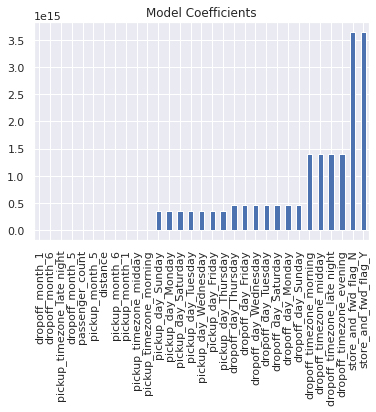

In [41]:
alg2 = LinearRegression(normalize=True)
y_pred=modelfit(alg2, X_train, X_test, predictor_cols,target_col)
coef1 = pd.Series(alg2.coef_[0], predictor_cols).sort_values()
coef1.plot(kind='bar', title='Model Coefficients')

we go with the residuals as variability of different features is different 

291302 291302


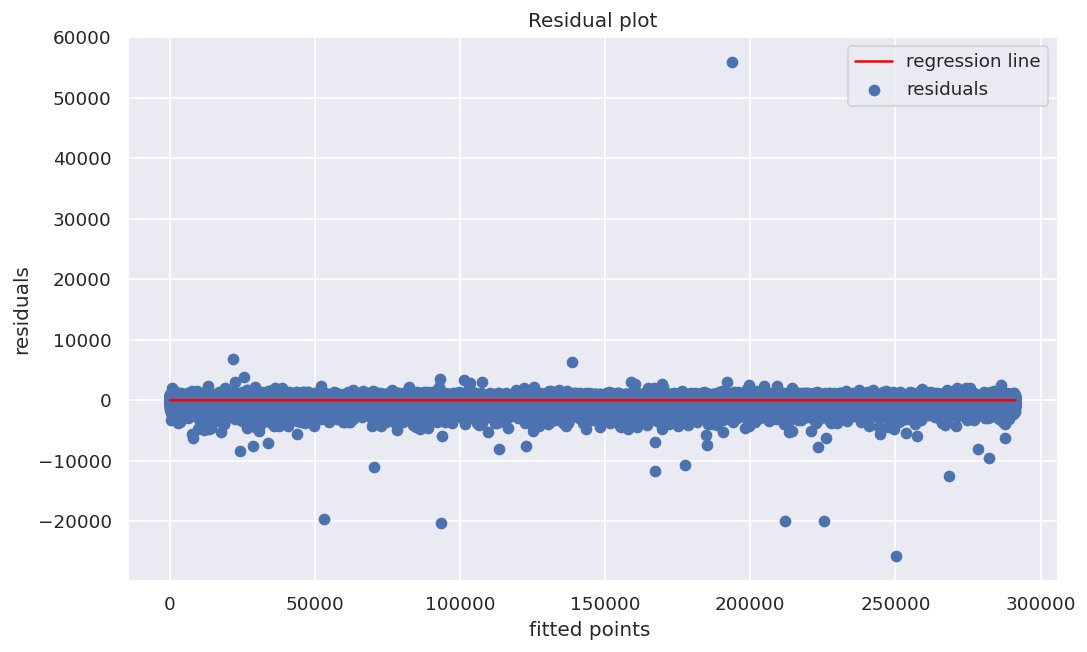

In [42]:
residuals=y_pred-X_test[target_col]#Heteroskedasticity
plt.figure(figsize=(10, 6), dpi=120, facecolor='w', edgecolor='b')
f = range(0,291302)
k = [0 for i in range(0,291302)]
print(len(f),len(residuals))
plt.scatter( f, residuals, label = 'residuals')
plt.plot( f, k , color = 'red', label = 'regression line' )
plt.xlabel('fitted points ')
plt.ylabel('residuals')
plt.title('Residual plot')
plt.legend()

cluster Model

In [43]:
data3=df_train.loc[:,['passenger_count','store_and_fwd_flag','pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude','trip_duration', 'pickup_day', 'pickup_month','pickup_timezone','speed','log_distance','distance']]
data3=pd.get_dummies(data3,columns=['store_and_fwd_flag','pickup_day','pickup_month','pickup_timezone'])

In [44]:
data3['pickup_latitude']=(data3['pickup_latitude']-data3['pickup_latitude'].mean())/data3['pickup_latitude'].std()

In [45]:
data3['pickup_longitude']=(data3['pickup_longitude']-data3['pickup_longitude'].mean())/data3['pickup_longitude'].std()
data3['dropoff_latitude']=(data3['dropoff_latitude']-data3['dropoff_latitude'].mean())/data3['dropoff_latitude'].std()
data3['dropoff_longitude']=(data3['dropoff_longitude']-data3['dropoff_longitude'].mean())/data3['dropoff_longitude'].std()
data3['trip_duration']=(data3['trip_duration']-data3['trip_duration'].mean())/data3['trip_duration'].std()
data3['speed']=(data3['speed']-data3['speed'].mean())/data3['speed'].std()
data3['distance']=(data3['distance']-data3['distance'].mean())/data3['distance'].std()
X_train_cluster, X_test_cluster = train_test_split(data3,test_size=validation_size, random_state=seed)

In [46]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=7, random_state=0).fit(X_train_cluster)

In [47]:
cluster = kmeans.predict(X_test_cluster)

(-15.0, 25.0)

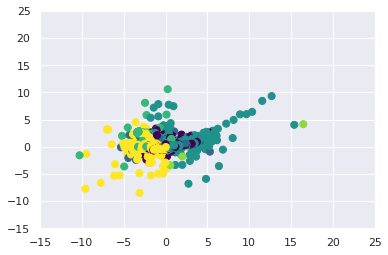

In [48]:
plt.scatter(X_test_cluster['pickup_latitude'], X_test_cluster['pickup_longitude'], c=cluster, s=50, cmap='viridis')
plt.xlim(-15,  25)
plt.ylim(-15, 25)


Initially intended to do this way, but due to limited Computing resources and cost for location query on foursquare API app I limited my analysis to only 20,000 values with location name.


Clustering values based on location name analysis as per different parts of the day like morning, midday, evening, late night

Code to generate train1.csv is : https://github.com/rohithkumar282/Coursera_Capstone/blob/master/Dataset_Preparation_train.ipynb

In [49]:
df_train1 = pd.read_csv('/content/train1.csv')

In [50]:
morning = df_train1[df_train1['pickup_timezone']=='morning']
midday = df_train1[df_train1['pickup_timezone']=='midday']
evening = df_train1[df_train1['pickup_timezone']=='evening']
latenight = df_train1[df_train1['pickup_timezone']=='late night'] 

morning_altered = morning[["index", "vendor_id","pickup_location","pickup_timezone","pickup_day"]]
midday_altered = midday[["index", "vendor_id","pickup_location","pickup_timezone","pickup_day"]]
evening_altered = evening[["index", "vendor_id","pickup_location","pickup_timezone","pickup_day"]]
latenight_altered = latenight[["index", "vendor_id","pickup_location","pickup_timezone","pickup_day"]]

mrng = morning_altered.groupby(["pickup_location", "pickup_timezone"])
middy = midday_altered.groupby(["pickup_location", "pickup_timezone"])
evng = evening_altered.groupby(["pickup_location", "pickup_timezone"])
latengt = latenight_altered.groupby(["pickup_location", "pickup_timezone"])

mrng_nos=[]
midday_nos=[]
evng_nos=[]
latenight_nos=[]
for key,item in mrng:
  a_group = mrng.get_group(key)
  mrng_nos.append([key[0],len(a_group)])

for key,item in middy:
  a_group = middy.get_group(key)
  midday_nos.append([key[0],len(a_group)])

for key,item in evng:
  a_group = evng.get_group(key)
  evng_nos.append([key[0],len(a_group)])

for key,item in latengt:
  a_group = latengt.get_group(key)
  latenight_nos.append([key[0],len(a_group)])
  
mrng_nos_dict={}
for i,j in mrng_nos:
  mrng_nos_dict[i] = j

midday_nos_dict={}
for i,j in midday_nos:
  midday_nos_dict[i] = j

evng_nos_dict={}
for i,j in evng_nos:
  evng_nos_dict[i] = j

latenight_nos_dict={}
for i,j in latenight_nos:
  latenight_nos_dict[i] = j

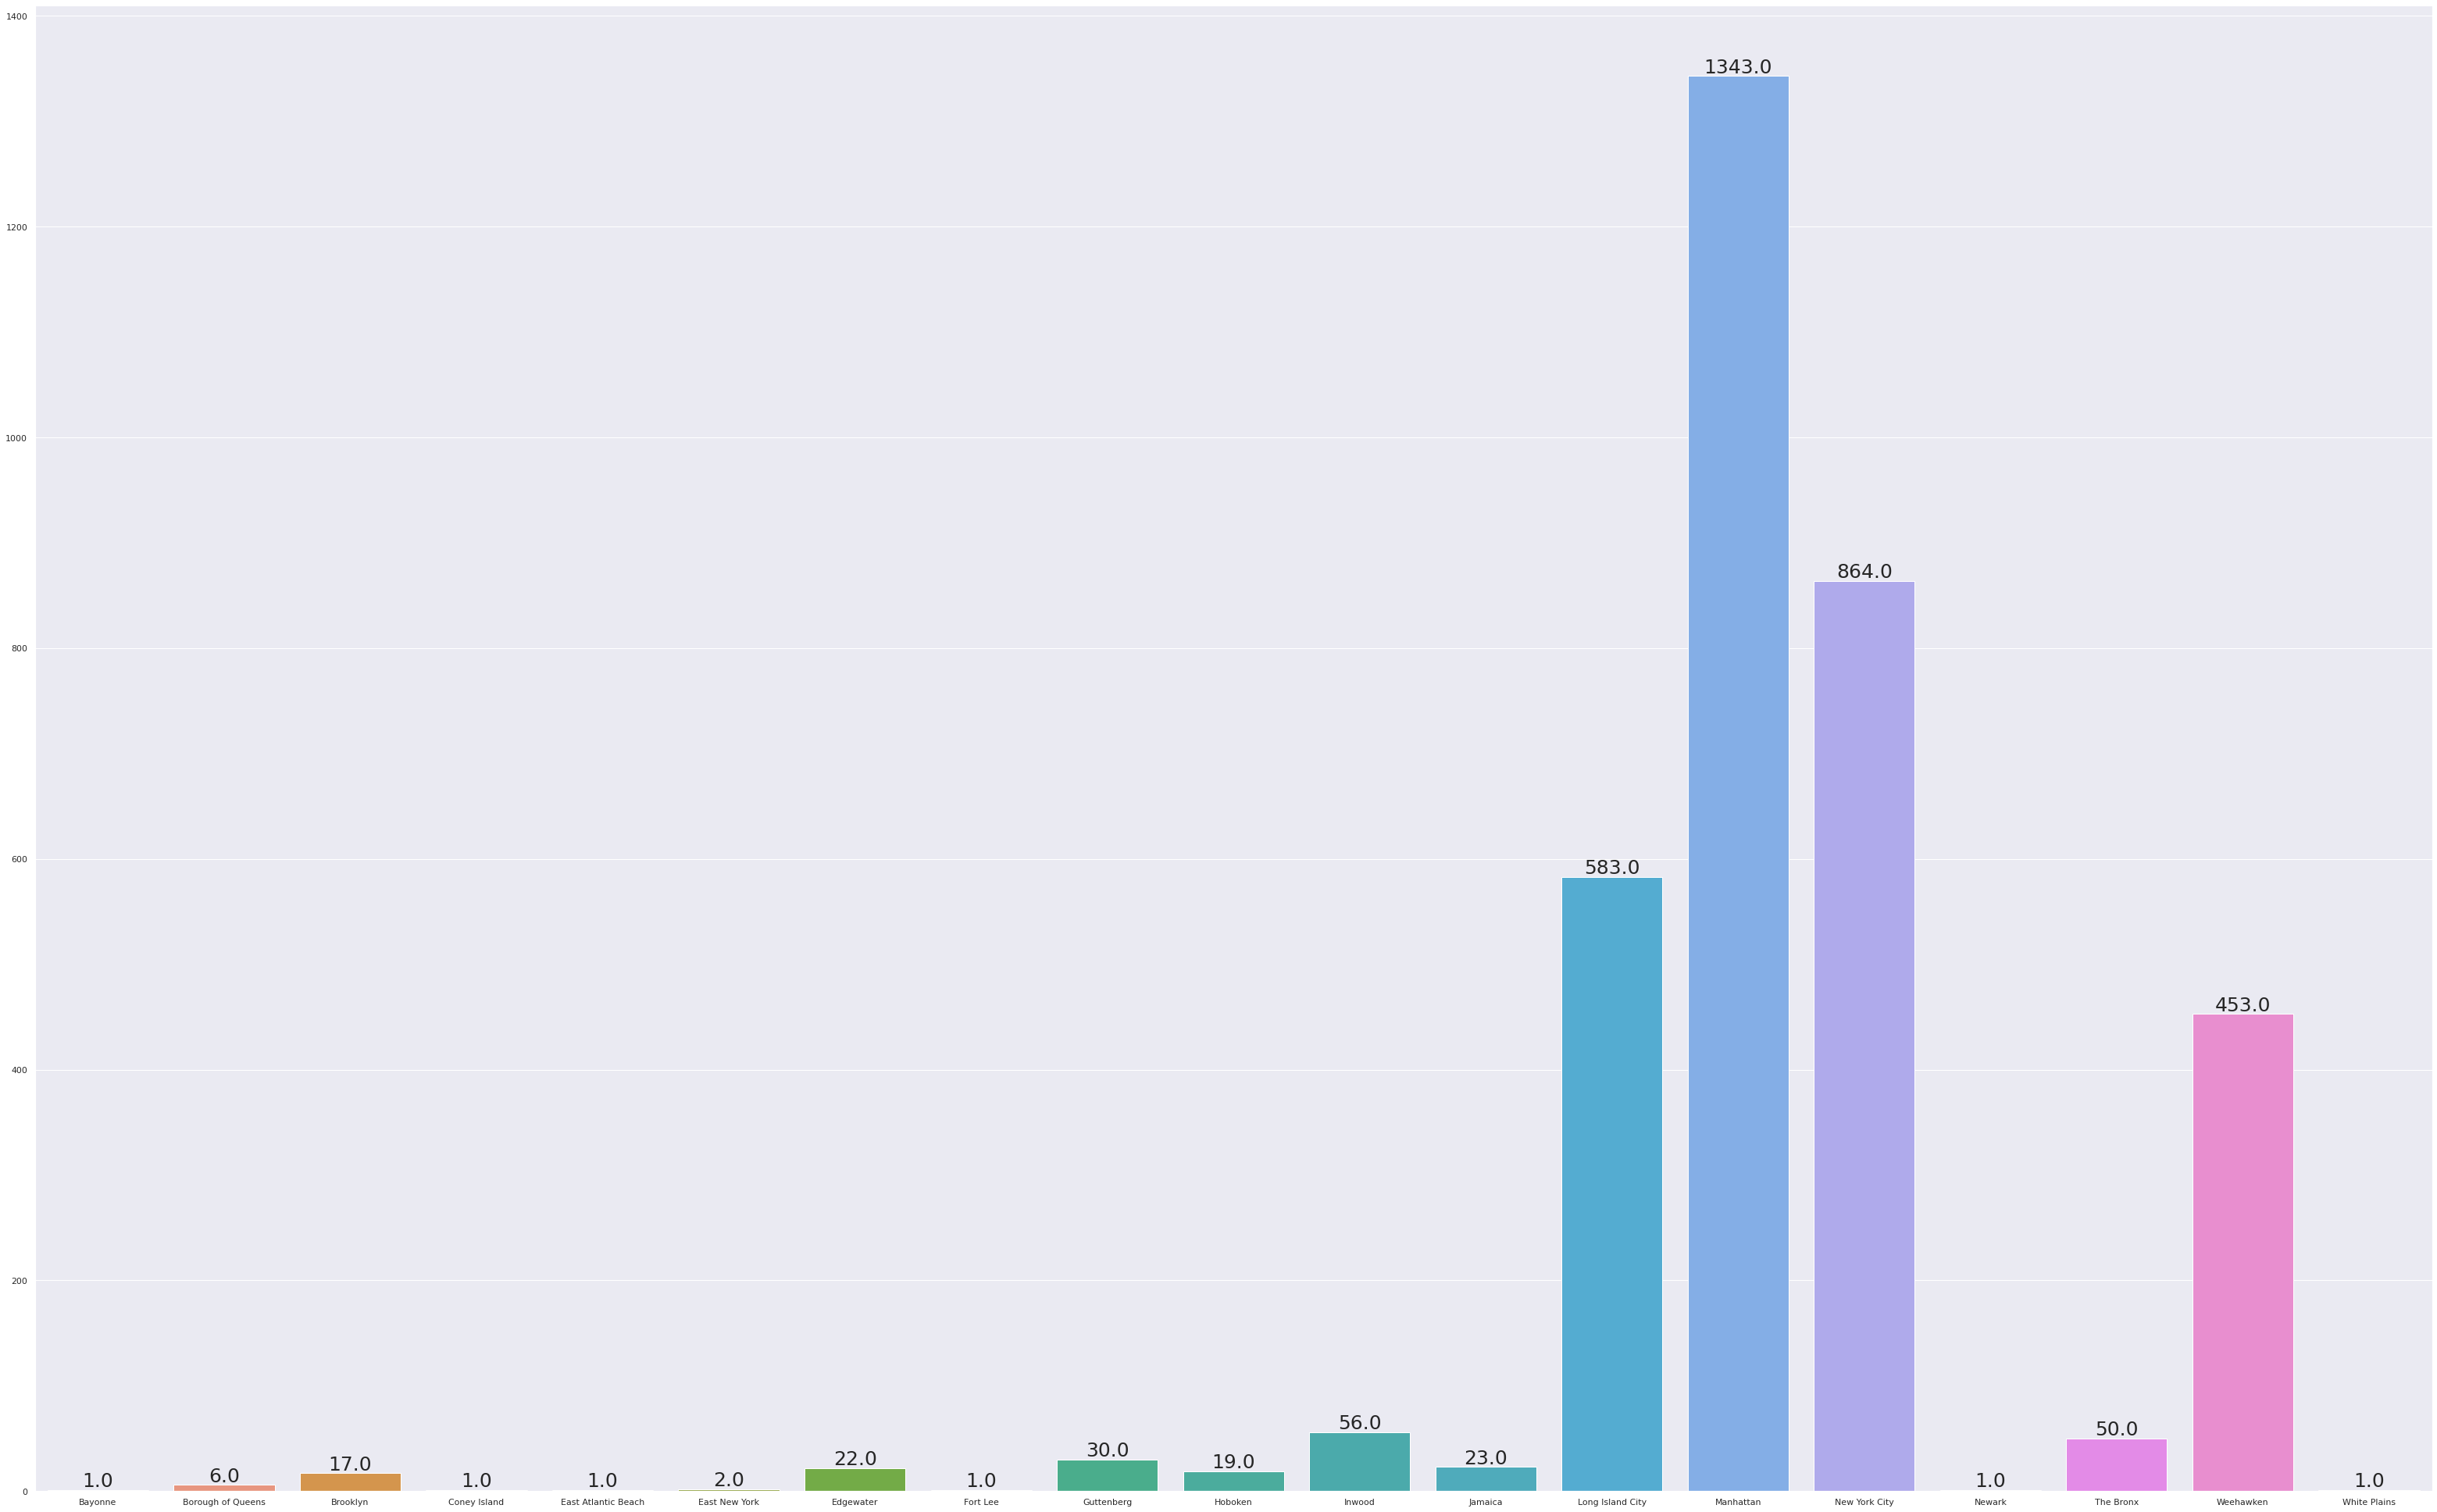

In [51]:
fig,ax = plt.subplots(figsize=(55,35))
g = sns.barplot(list(mrng_nos_dict.keys()), list(mrng_nos_dict.values()),ax=ax)
for p in g.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,height + 3,height,ha="center",fontsize=25)

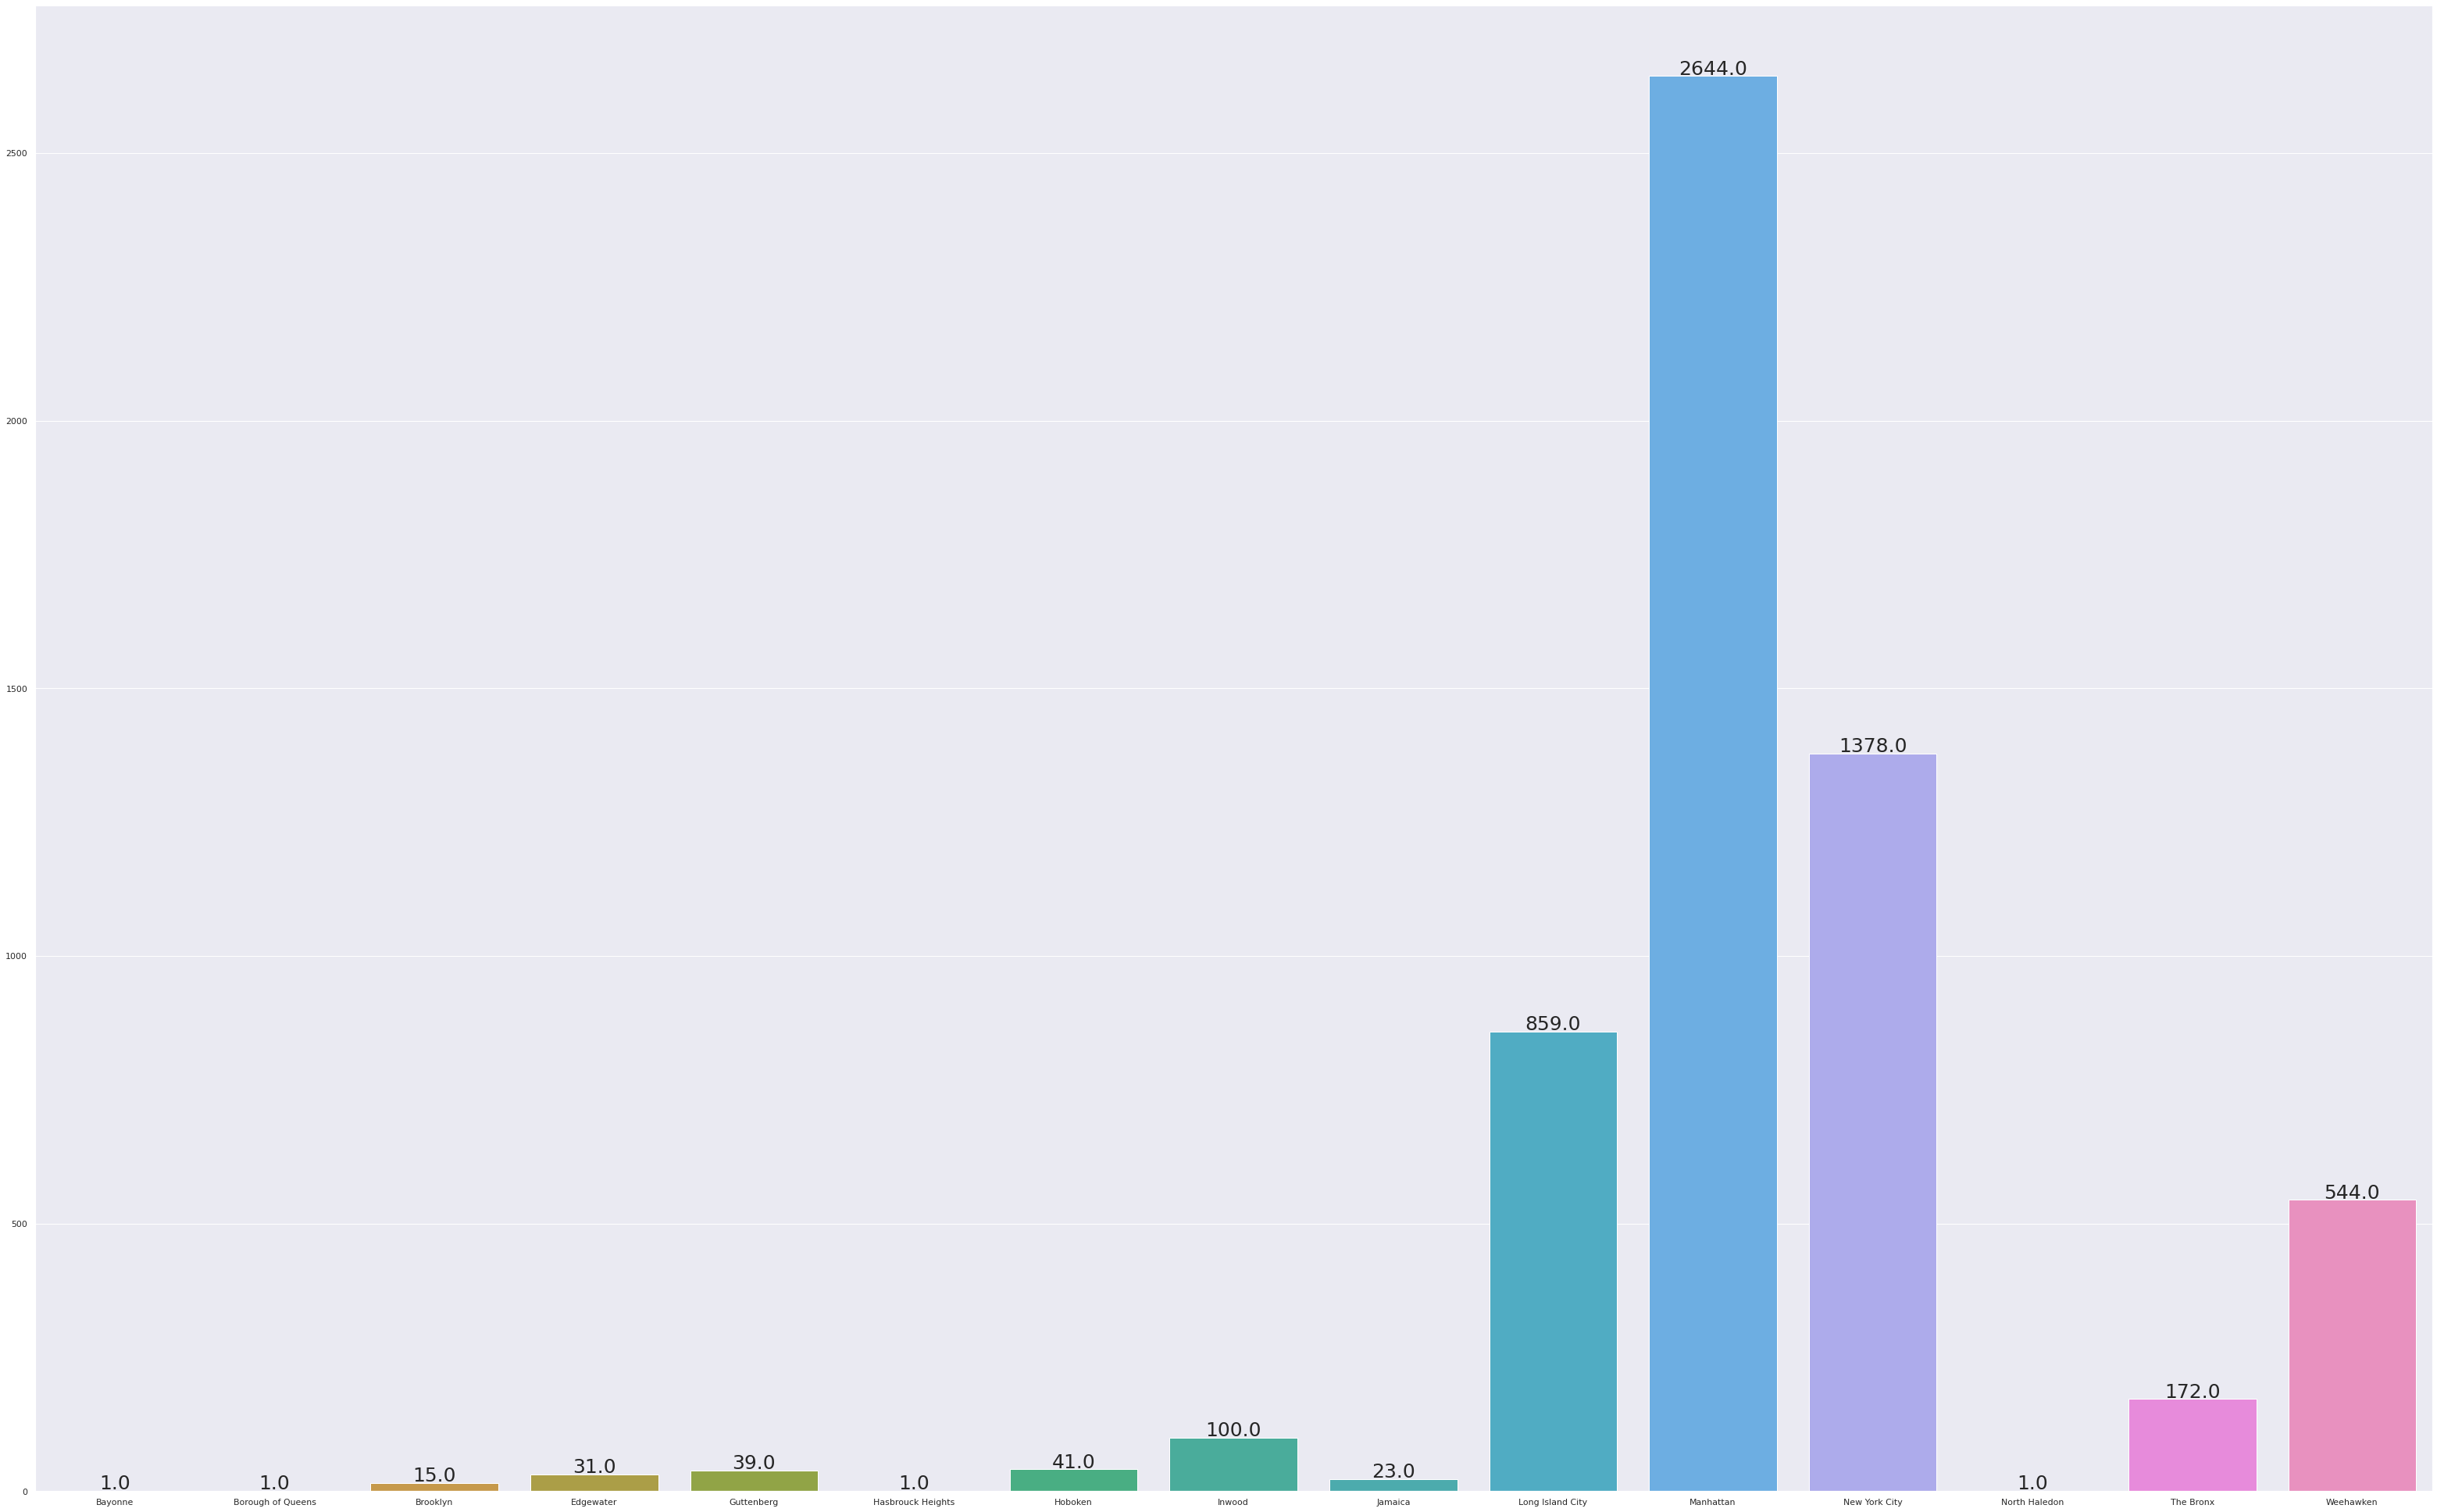

In [52]:
fig,ax = plt.subplots(figsize=(55,35))
g = sns.barplot(list(midday_nos_dict.keys()), list(midday_nos_dict.values()),ax=ax)
for p in g.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,height + 3,height,ha="center",fontsize=25)

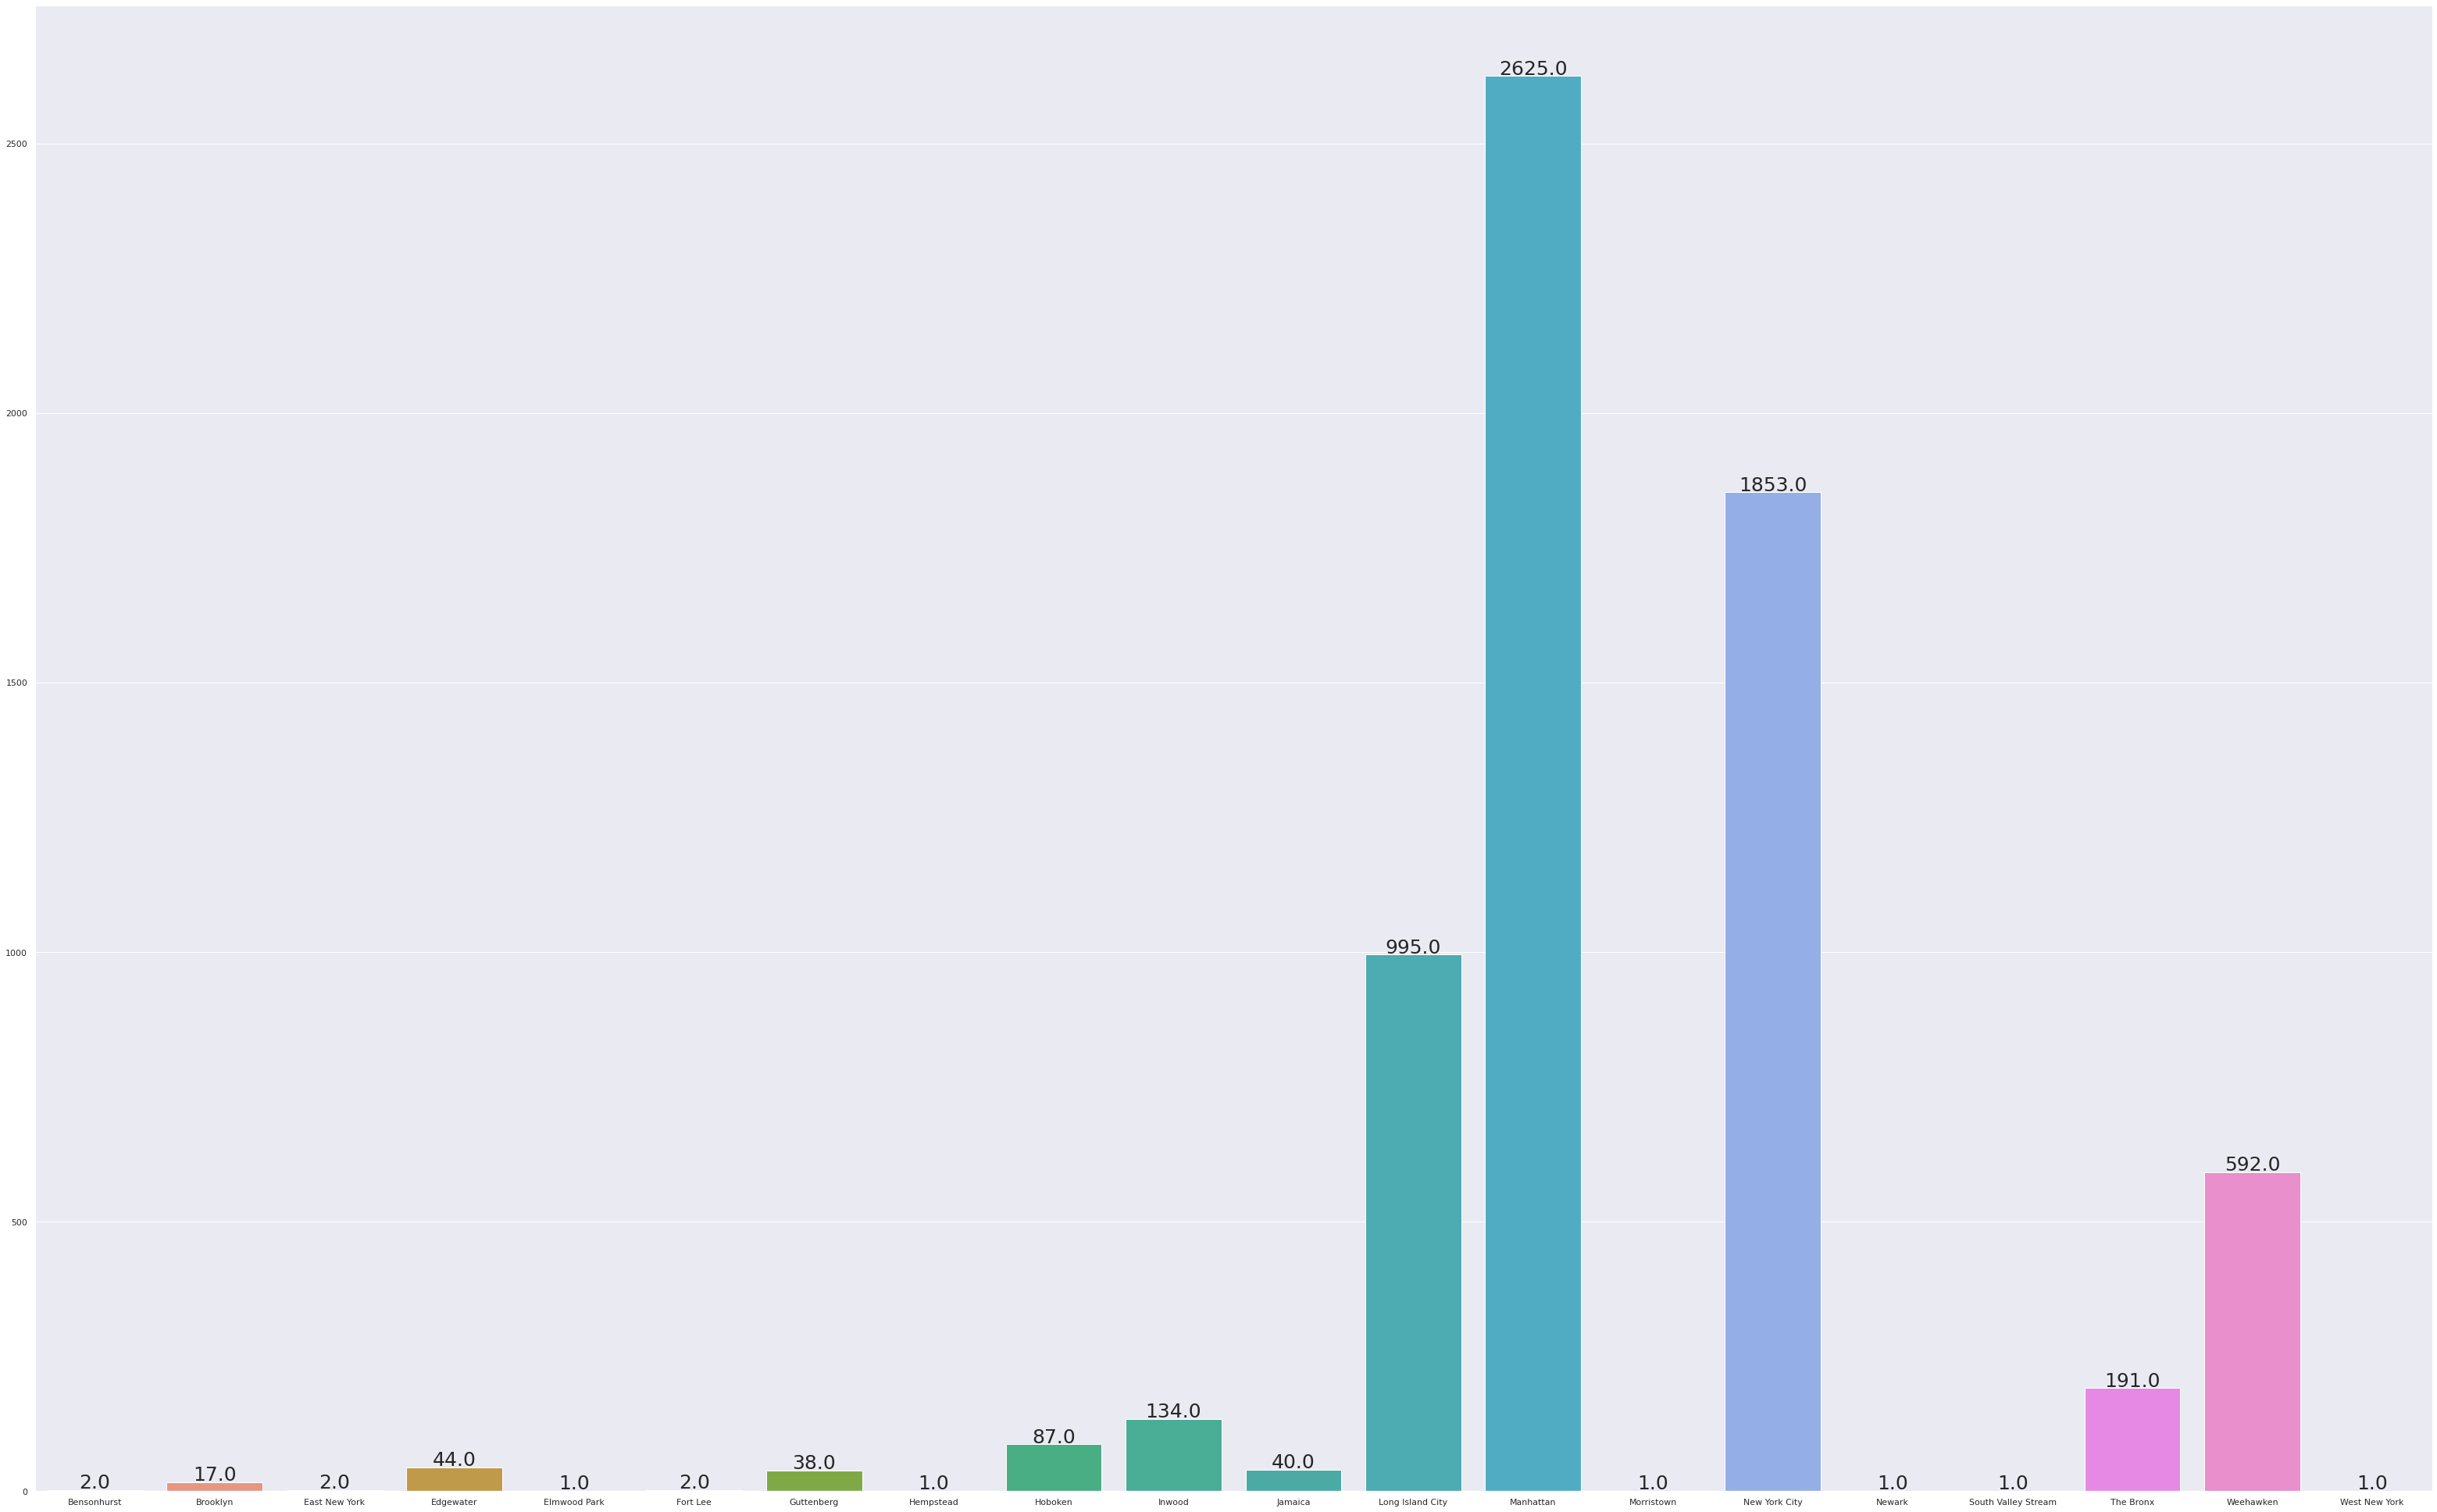

In [53]:
fig,ax = plt.subplots(figsize=(55,35))
total = float(len(evng_nos_dict))
g = sns.barplot(list(evng_nos_dict.keys()), list(evng_nos_dict.values()),ax=ax)
for p in g.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,height + 3,height,ha="center",fontsize=25)

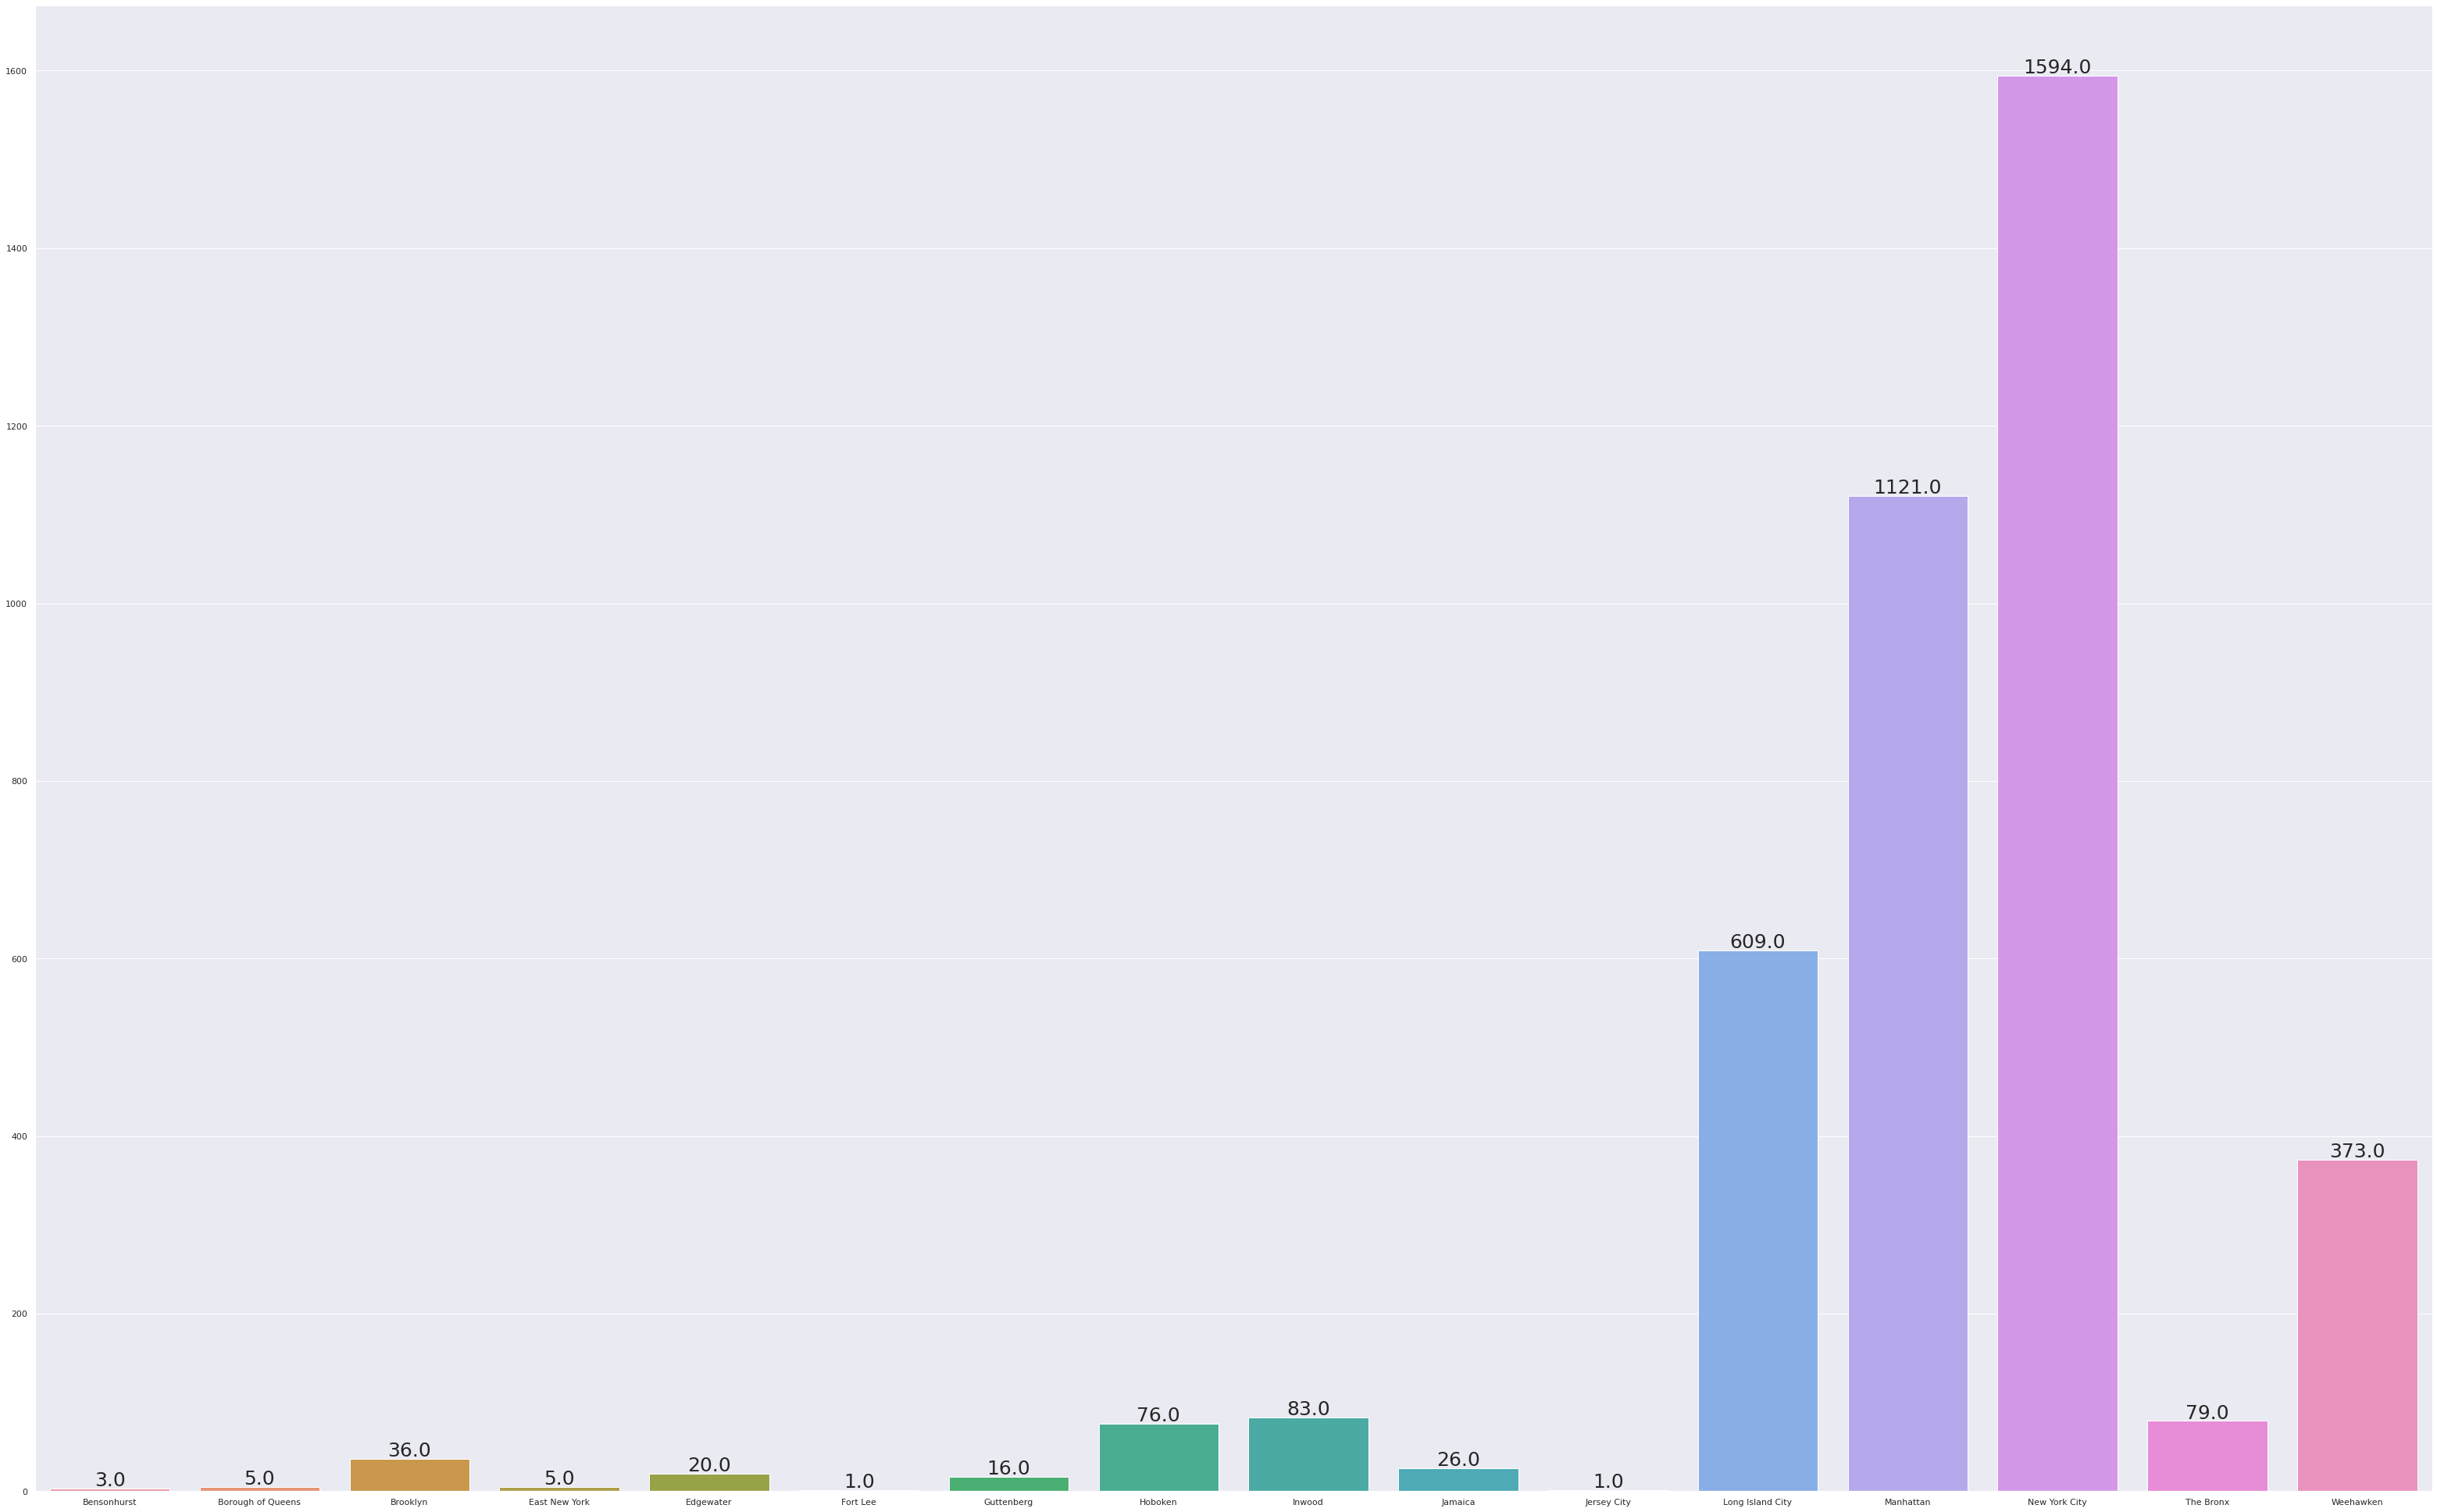

In [54]:
fig,ax = plt.subplots(figsize=(55,35))
g = sns.barplot(list(latenight_nos_dict.keys()), list(latenight_nos_dict.values()),ax=ax)
for p in g.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,height + 3,height,ha="center",fontsize=25)